# Process Köppen climate zones dataset 

And intersect with landcover to give us climate-landcover classes

gdal_translate -of "GTiff" kpngrp.txt kpngrp.tif

In [1]:
import rioxarray as rxr
import xarray as xr
import numpy as np
from odc.geo.xr import assign_crs

import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import round_coords

/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
koppen = rxr.open_rasterio('/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/kpngrp.tif').squeeze().drop_vars('band')
koppen = koppen.where(koppen>-9999)

# Dataset to reproject too and land-sea mask
rain = xr.open_dataset('/g/data/os22/chad_tmp/AusENDVI/data/5km/rain_5km_monthly_1981_2022.nc')['rain']
rain = rain.sel(time=slice('2000', '2010')).mean('time')
mask = (~np.isnan(rain))
gbox=rain.odc.geobox

## Reclasssify

In [3]:
desert = [21,22,23,24]
grassland = [11,12,13,14,15]
temperate = [1,2,3,4,5,6,7,8,9]
subtropical = [31,32,33,34]
tropical = [35,36,37]
equatorial = [41,42]

regions = {i:r for i,r in zip(range(50,57), [desert,grassland,temperate,subtropical,tropical,equatorial])}

for k,r in regions.items():
    koppen = xr.where(koppen.isin(r), k, koppen)

koppen = assign_crs(koppen, crs='epsg:4326')
koppen = koppen.odc.reproject(gbox,resampling='mode')
koppen = round_coords(koppen)
koppen = assign_crs(koppen, crs='epsg:4326')
koppen = koppen.where(mask)

## Export

In [4]:
koppen.to_netcdf('/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/koppen_major_climate_zones.nc')

## Plot

In [5]:
import distinctipy
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LinearSegmentedColormap

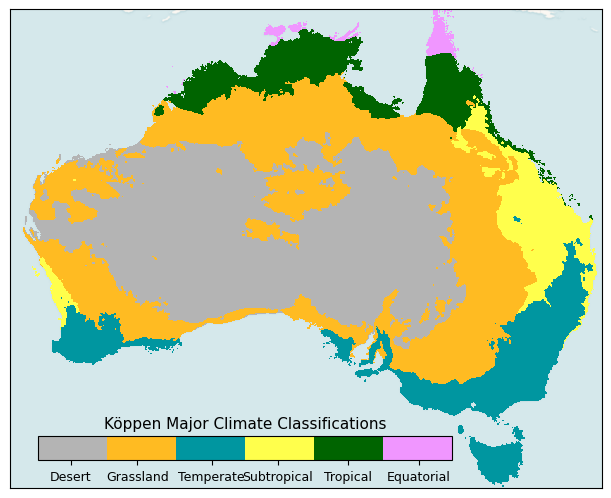

In [46]:
fig,ax = plt.subplots(1,1, figsize=(6,5), layout='constrained')

categories =['Desert', 'Grassland', 'Temperate', 'Subtropical', 'Tropical', 'Equatorial']
colours = ['#b4b4b4',  '#ffbb22',   '#0096a0',     '#ffff4c',  '#006400'  ,   '#f096ff']

cmap = LinearSegmentedColormap.from_list("landcover_cmap", colours, N=len(colours))

im = koppen.plot(cmap=cmap, ax=ax, add_colorbar=False, add_labels=False)
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)

axins1 = inset_axes(ax,width="70%",height="5%",loc="lower left", borderpad=2)
cbar = fig.colorbar(im, cax=axins1, ticks=[50.4, 51.20, 52.1, 52.9, 53.75, 54.6], orientation='horizontal')
cbar.ax.set_title('Köppen Major Climate Classifications', fontsize=11);
cbar.ax.set_xticklabels(categories, fontsize=9);

fig.savefig("/g/data/os22/chad_tmp/Aus_CO2_fertilisation/results/figs/Koppen_climate_classification.png",
            bbox_inches='tight', dpi=300)

## Now intersect with landcover

<!-- lc:
* 1=Tree
* 2=Shrub
* 3=grass
* 4=shrub
* 5=crop
* irrigated=6

koppen:
* 51=Desert
* 52=grassland
* 53=temperate
* 54=subtropical
* 55=tropical
* 56=equatorial

Koppen * lc:
* 51=Desert+tree
* 52=Grassland+tree
* 53=Temperate+tree
* 54=Subtropical+tree
* 55=Tropical+tree
* 56=Equatorial+tree
* 102=Desert+shrub
* 104=Grassland+shrub
* 106=Temperate+shrub (422 pixels)
* 108=Subtropical+shrub (174 pixels)
* 110=Tropical+shrub (539 pixels)
* 112=Equatorial+shrub (1 pixel)
* 153=Desert+Grass
* 156=Grassland+grass
* 159=Temperate+grass
* 162=Subtropical+grass
* 165=Tropical+grass
* 168=Equatorial+grass (31 pixels) -->

In [33]:
lc = xr.open_dataarray('/g/data/os22/chad_tmp/Aus_phenology/data/ESA_WorldCover_processed.nc')
lc = lc.where(lc<=3)

koppen_adju = koppen+1
koppen_and_lc = koppen_adju*lc #mulitply to get unique lc-climate classes

In [34]:
#number of pixels in each category
for i in np.unique(koppen_and_lc)[0:-1]:
     print(int(i),':', np.sum(~np.isnan(koppen_and_lc.where(koppen_and_lc==i))).item())

51 : 911
52 : 14693
53 : 12165
54 : 8200
55 : 13060
56 : 1422
102 : 27638
104 : 14128
106 : 422
108 : 174
110 : 539
112 : 1
153 : 69998
156 : 57814
159 : 3117
162 : 6400
165 : 6131
168 : 31


## Reclassify

In [35]:
# drop categories with < 1000 pixels
koppen_and_lc = xr.where(koppen_and_lc==112, np.nan, koppen_and_lc) #equatorial shrub
koppen_and_lc = xr.where(koppen_and_lc==108, np.nan, koppen_and_lc) #subtropical shrub
koppen_and_lc = xr.where(koppen_and_lc==110, np.nan, koppen_and_lc) #tropical shrub
koppen_and_lc = xr.where(koppen_and_lc==106, np.nan, koppen_and_lc) #temperate shrub
koppen_and_lc = xr.where(koppen_and_lc==168, np.nan, koppen_and_lc) #Equatorial grass
koppen_and_lc = xr.where(koppen_and_lc==168, np.nan, koppen_and_lc) #Equatorial grass

#make desert-tree into grassland-tree as its just a few pixels along the border
koppen_and_lc = xr.where(koppen_and_lc==51, 52, koppen_and_lc)

#make numbers sequential now
new = [57,58,59,60,61,62,63,64]
old = [102,104,153,156,159,162,165,168]

for r,k in {i:r for i,r in zip(old,new)}.items():
    koppen_and_lc = xr.where(koppen_and_lc.isin(r), k, koppen_and_lc)

koppen_and_lc = koppen_and_lc-52 #make categories 0-12 instead of 51-64

In [36]:
kopp_cat =['Desert\n', 'Grassland\n', 'Temperate\n', 'Subtropical\n', 'Tropical\n', 'Equatorial\n']

categories=[]
for k in kopp_cat:
    categories.append(k+'-'+'Tree')
for k in kopp_cat:
    categories.append(k+'-'+'Shrub')
for k in kopp_cat:
    categories.append(k+'-'+'Grass')

categories.remove('Equatorial\n-Shrub')
categories.remove('Subtropical\n-Shrub')
categories.remove('Tropical\n-Shrub')
categories.remove('Temperate\n-Shrub')
categories.remove('Equatorial\n-Grass')
categories.remove('Desert\n-Tree')

cat_dict = {i:c for i,c in zip(np.unique(koppen_and_lc)[0:-1],categories)}

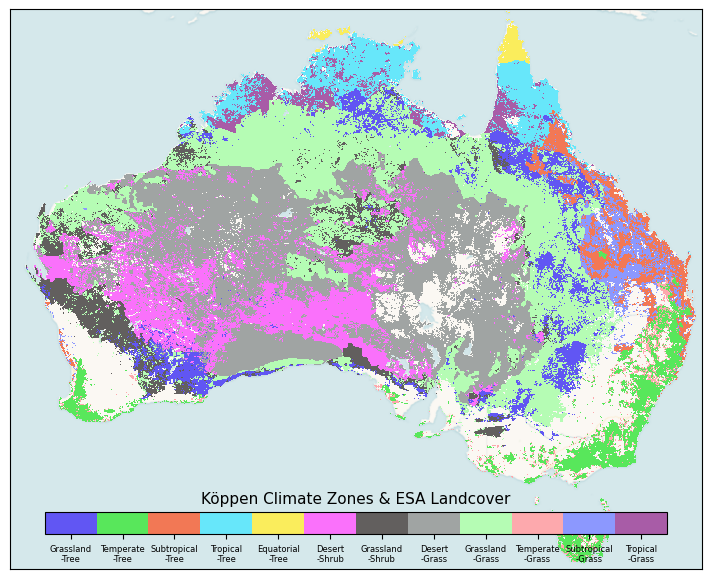

In [43]:
fig,ax = plt.subplots(1,1, figsize=(7,6), layout='constrained')

colours = distinctipy.get_colors(len(categories), pastel_factor=0.5, rng=2)
cmap = LinearSegmentedColormap.from_list("cwc", colours, N=len(categories))

im = koppen_and_lc.plot(cmap=cmap, ax=ax, add_colorbar=False, add_labels=False)
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)

axins1 = inset_axes(ax ,width="90%",height="4%",loc="lower left", borderpad=2.5)  
cbar = fig.colorbar(im, cax=axins1, ticks=(np.arange(len(categories))+0.5)*(len(categories)-1)/(len(categories)), orientation='horizontal')
cbar.ax.set_title('Köppen Climate Zones & ESA Landcover', fontsize=11);
cbar.ax.set_xticklabels(categories, fontsize=6);

fig.savefig("/g/data/os22/chad_tmp/Aus_CO2_fertilisation/results/figs/Koppen_and_landcover_classification.png",
            bbox_inches='tight', dpi=300)

In [44]:
koppen_and_lc.to_netcdf('/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/koppen_and_landcover.nc')